# Exploration
In this document we work using a new method, based on tree. In the previous exploration we mentioned that the classification using logistic regression is associated with linearity speration and there is no regularisation in the Python environment for logistic regression, it is possible to implement regularisation but we did not take this option yet (perhaps later).
Tree oriented is a solution to avoid the instabilty associated with linearity separation, in this document we explore the mixed effect based on the customers (Hot, Warm), this couls allow us to build one model instead of two. 

For information mixed effect has been tested with statmodels, the implementation of the logitic or mixed effect was not able to deal with the near singularity of the desing matrix, therefore Boosting could be a solution. 

The tree boosting gives very good results to be taken with care as we do not use a valiadation set. 

In [148]:
import gpboost as gpb
import pandas  as pd
import numpy   as np
import vtreat
# For some display
import matplotlib.pyplot as plt
# for the end 
from sklearn.metrics  import confusion_matrix

# The data set
We import the same data set as in the model notebook after pre process of the varaibles project_status and type. In the model document we use the conditional probability of the the effect after the transformation of type, as we rae with tree we shall do the following:

1. Test the mixed effect boostiong without conditional probability
2. Test with with conditional probability

In [10]:
# We read our data they have been prepared
all_data = pd.read_csv("../data/dulux_preprocess.csv")

For information, we have the following variables in this data set, as mentioned we use a sub-set. As note we can admire the precision of Python!!!

## Transformation for mixed effect
As we work with mixed model we have other transformations, 

As in the model, we build Hot and Warm, we shall work on Hot only in this document as we do an exploration. 

In [117]:
# We do a log transformed and then split in warm and hot 
# The varaibles used have been selected based on the analysis of the effect
all_data['log_value']  = np.log(all_data['value'])
variable_name =['opportunity','type','log_value', 'account_state', 'project_status', 'projectstage', 'consistency_status_code_text', 'life_cycle_status_code_text','qualification_level_code_text']
# Split 
warm_data  = all_data[ all_data['qualification_level_code_text'] =='Warm']
hot_data   = all_data[ all_data['qualification_level_code_text'] =='Hot' ]
#  Reduce 
col_pos =[]
for ref in variable_name:
        col_pos.append(all_data.columns.get_loc(ref))
        
warm_data  = warm_data.iloc[:,col_pos]    
hot_data   = hot_data.iloc[:,col_pos]    
all_model_data = all_data.iloc[:,col_pos]
# We have to build the grouping of qualification_level_code_text
group_qual = np.where(all_model_data['qualification_level_code_text'] =='Warm',0,1)
params_delux = { 'objective': 'regression_l2', 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 5, 'verbose': 0 }        
#  Build tfor data set boostion mixed effect 
response_mixed = np.array( all_model_data['opportunity'])
variable_mixed   = all_model_data.drop(['opportunity','qualification_level_code_text' ], axis=1)


In [132]:
# Hot encoding the function using pandas for hot encosing 
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)
to_encode =[ 'type','account_state', 'project_status', 'projectstage', 'consistency_status_code_text', 'life_cycle_status_code_text']
# test = encode_and_bind(variable_mixed , 'type' )
variable_mixed_encoded = variable_mixed
for feature in to_encode:
    variable_mixed_encoded = encode_and_bind(variable_mixed_encoded, feature)

After hot encodding we can proceed, with boosting 

In [135]:
mixed_model_train = gpb.Dataset(variable_mixed_encoded , response_mixed)
gaussian_mixed  = gpb.GPModel(group_data=group_qual)
boost_mixed     = gbp.train(params=params_delux, train_set=mixed_model_train, gp_model=gaussian_mixed, num_boost_round=32)

[GPBoost] [Warning] Find whitespaces in feature_names, replace with underlines


We do the rediction and then the metrics, the point we are binary there so we have to check the distribution

In [138]:
opportunity_predict = boost_mixed.predict(data=variable_mixed_encoded, group_data_pred=group_qual)
y_pred = opportunity_predict['fixed_effect'] + opportunity_predict['random_effect_mean'] # sum predictions of fixed effect and random effect
print(np.sqrt(np.mean((response_mixed - y_pred) ** 2)) )# root mean square error (RMSE) on test data. Approx. = 1.25

0.18099118531770864


The prediction distritbution is the following, we can notice the upper prediction

Text(0, 0.5, 'Frequency')

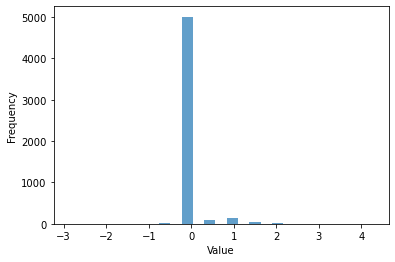

In [141]:
n, bins, patches = plt.hist(x=y_pred, bins='auto', alpha=0.7, rwidth=0.5)
plt.xlabel('Value')
plt.ylabel('Frequency')

As in case of probability we do a cut-off at .5 , the result is perfect. We certainly over fit but still with out of bag we can check this surprising results, if it hold. The out of bag will have to be build with care as we have some category with low cardinality, one taken out could be better if we could afford the computation. 

In [156]:
predict_corrected = np.where(response_mixed > .5 ,1,0)
hot_matrix   = confusion_matrix(response_mixed, predict_corrected)
print(hot_matrix)

[[5041    0]
 [   0  301]]


### Variables of importance 
As we want some explanation we add the varaiable of importance, as expected the most important is the log value with project status and location WA, which is new in way that it appears after clusetring during the first EDA, follow by big_effect which is the synthatic value and type commercial. 
The main change here is WA which appears as highly rated. 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

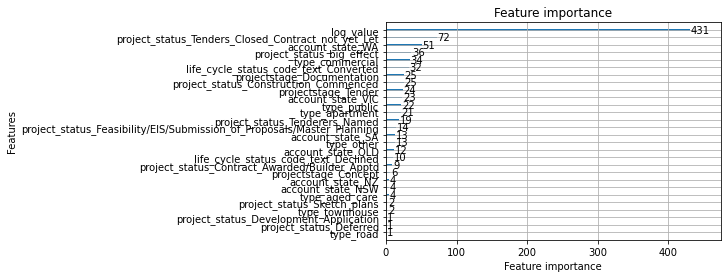

In [157]:
gpb.plot_importance(boost_mixed)

# Example mixed model & Boosting
The follwing lines were a test of some random effects, to check how the model reacts. 

In [66]:
import sklearn.datasets as datasets
m       = 500  # number of categories / levels for grouping variable
n       = 10000
ntrain  = 5000
np.random.seed(35)
rd_x, rd_f = datasets.make_friedman3( n_samples=ntrain)  # Non linear generation
#  Build the  variates
pd_x = pd.DataFrame(rd_x,columns=['variable_1','variable_2','variable_3','variable_4'])
# The fixed effect 
rd_f = rd_f * 10**0.5

Show the fixed effect distribution 

(0.0, 800.0)

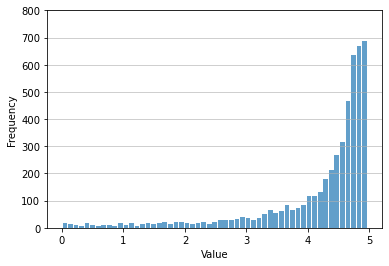

In [68]:
n, bins, patches = plt.hist(x=rd_f, bins='auto', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.ylim(ymax=800)


In [69]:
# Simulate random effects we build the groups index 
group_train = np.arange(ntrain)  # grouping variable
for i in range(m):
    group_train[int(i * ntrain / m):int((i + 1) * ntrain / m)] = i

We build the train data set with response and random effect 

In [70]:
#  Build the random effect 
sigma2_1 = 1  # random effect variance
sigma2 = 1 ** 2  # error variance
b = np.sqrt(sigma2_1) * np.random.normal(size=ntrain)  # simulate random effects

Zb = b[group_train]
# Put everything together for the response
xi = np.sqrt(sigma2) * np.random.normal(size=ntrain)  # simulate error term
y = rd_f + Zb + xi  # observed data

In [109]:
type(y)

numpy.ndarray

In [ ]:
Build the model using the GP boost with example 

In [81]:
# Define and train GPModel
gp_model = gpb.GPModel(group_data=group_train)
# create dataset for gpb.train function
data_train = gpb.Dataset(pd_x, y)
# specify tree-boosting parameters as a dict
params = { 'objective': 'regression_l2', 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 5, 'verbose': 0 }
# train model
bst = gpb.train(params=params, train_set=data_train, gp_model=gp_model, num_boost_round=32)

In [ ]:
We predict on the train set here, we did no build a test set as we explore. The result is not really great. 

In [83]:
# Make predictions
pred = bst.predict(data=pd_x, group_data_pred=group_train)
y_pred = pred['fixed_effect'] + pred['random_effect_mean'] # sum predictions of fixed effect and random effect
print(np.sqrt(np.mean((y - y_pred) ** 2)) )# root mean square error (RMSE) on test data. Approx. = 1.25

0.9003394820504346


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

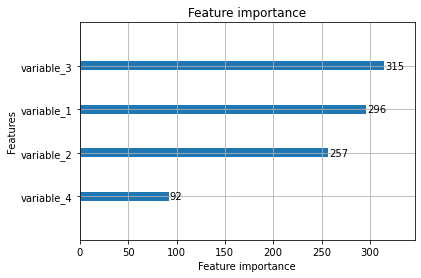

In [80]:
# Plotting feature importances
gpb.plot_importance(bst)